In [48]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

#   Part 1 – Scenario Selection

## Chicago Airbnb  Scenario

You and a group of friends are considering purchasing a property in Chicago that you can use as an investment. You have heard from other people that they have made a lot of money by renting out either a room or an entire unit (apartment or house). Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase.


# Part 2 – Split and Store your data

#  Data Loading and Initial Splitting 

In [49]:
df = pd.read_csv("listings.csv")

# Randomly selecting 100 rows for live data

In [50]:

live_data = df.sample(n=100, random_state=42)
live_data.to_csv("live_data.csv", index=False)

random_state is crucial for reproducibility. It ensures that every time we run the code we will  get the same 100 rows.Without it each run would produce a different sample making it difficult to compare results.i am  saving the live_data DataFrame to a CSV file named live_data.csv  and index=False Prevents the DataFrame index from being written to the CSV file.

# Removing live data from the original DataFrame

In [51]:

df = df.drop(live_data.index)

here  i am removing the 100 sampled rows from the original df DataFrame.

In [6]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,45514091,Best view of Chicago downtown + optional parking,367907062,Melanie And Ryan,NaN,Near South Side,41.85574,-87.62507,Entire home/apt,146,2,0,NaN,NaN,4,180
6393,45514389,Luxurious 3Br/2Ba with optional parking and View,367907062,Melanie And Ryan,NaN,Near South Side,41.85561,-87.62342,Entire home/apt,195,2,0,NaN,NaN,4,180
6394,45514632,Two story Penthouse w private Rooftop & Great ...,367907062,Melanie And Ryan,NaN,Near South Side,41.85584,-87.62404,Entire home/apt,493,2,0,NaN,NaN,4,177
6395,45515281,West Town Private Room,347064639,Ali,NaN,West Town,41.89005,-87.66668,Private room,53,32,0,NaN,NaN,1,83



#  Storing Data in PostgreSQL

# database details

In [18]:
host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'12345'
port = r'5432'
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [19]:
df.to_sql('airbnb_data_raw',db_conn , schema='raw', if_exists='replace', index=False)

123

Here i used index=False in  to_sql command to prevent the DataFrame's index from being written as a separate column in the database table. In most cases the index is an internal Pandas construct and is not needed in the database.if_exists='replace is used to instruct Pandas to replace the existing table if it already exists. This ensures that we always have a fresh copy of the data in the database, avoiding potential conflicts or inconsistencies and the data is written to the postgresql from the data frame using to_sql

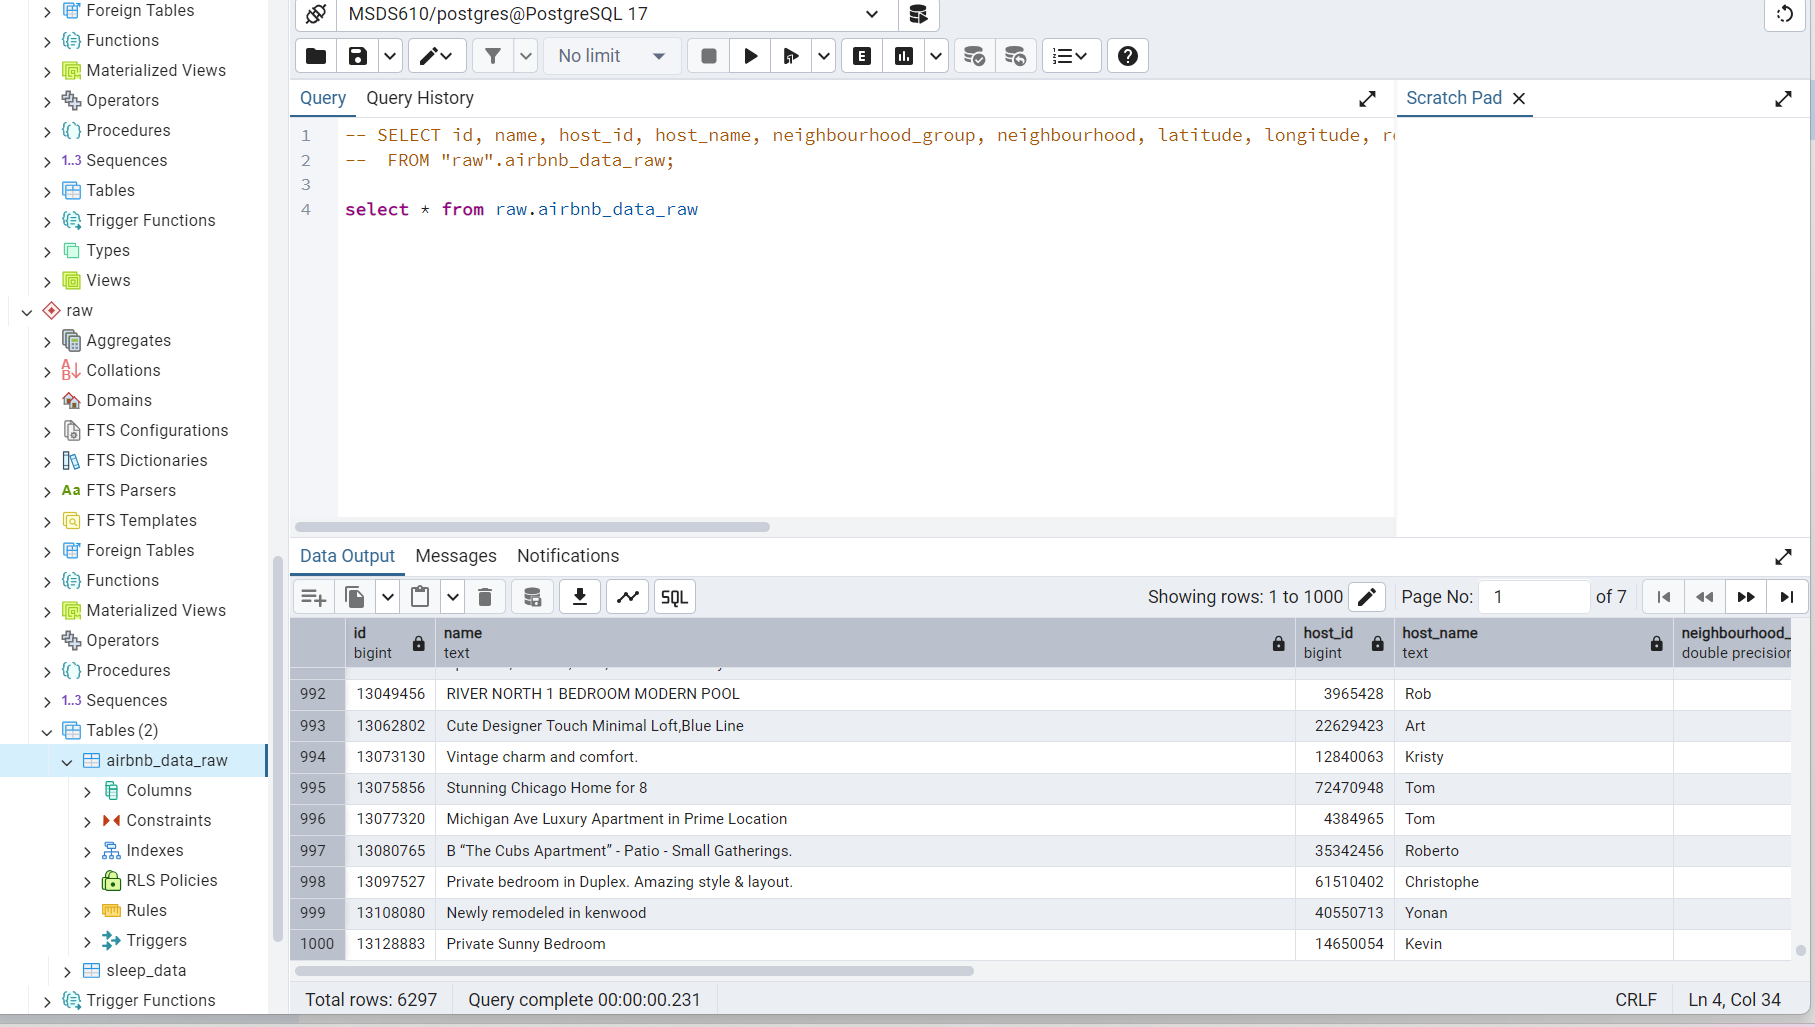

THis shows that the data is loaded into the database of raw schema and airbnb_data_raw table.It confirms that the data from the file was successfully loaded and stored in the database.We can see that the table contains 6297 rows, which matches the number of rows in our original DataFrame after removing the live data. The table includes the expected columns, such as 'id', 'name', 'host_id', and 'neighbourhood'.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6396
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6297 non-null   int64  
 1   name                            6297 non-null   object 
 2   host_id                         6297 non-null   int64  
 3   host_name                       6297 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6297 non-null   object 
 6   latitude                        6297 non-null   float64
 7   longitude                       6297 non-null   float64
 8   room_type                       6297 non-null   object 
 9   price                           6297 non-null   int64  
 10  minimum_nights                  6297 non-null   int64  
 11  number_of_reviews               6297 non-null   int64  
 12  last_review                     5183 no

# Part 3 –Data Definition and Analytical Question

## Data Definition

| Field Name                       | Description                                                                  | Data Type    |
|-----------------------------------|------------------------------------------------------------------------------|--------------|
| id                                | Unique identifier for each listing                                          | Discrete     |
| name                              | Name of the listing                                                         | Nominal      |
| host_id                           | Unique identifier for the host                                              | Discrete     |
| host_name                         | Name of the host                                                            | Nominal      |
| neighbourhood_group               | Group of neighborhoods (e.g., North Side, South Side)                      | Nominal      |
| neighbourhood                     | Specific neighborhood where the property is located                         | Nominal      |
| latitude                          | Latitude coordinate of the property                                         | Continuous   |
| longitude                         | Longitude coordinate of the property                                        | Continuous   |
| room_type                         | Type of room offered (e.g., entire home/apt, private room, shared room)    | Nominal      |
| price                             | Price per night in USD                                                      | Continuous   |
| minimum_nights                    | Minimum number of nights a guest can stay                                 | Discrete     |
| number_of_reviews                 | Number of reviews received                                                  | Discrete     |
| last_review                       | Date of the most recent review                                              | Ordinal      |
| reviews_per_month                 | Number of reviews per month                                                 | Continuous   |
| calculated_host_listings_count    | Number of listings the host has                                             | Discrete     |
| availability_365                  | Number of days the listing is available within a year                      | Discrete     |



## Analytical Question

**Question:** What key factors influence the nightly price of an Airbnb listing in Chicago, and how can these factors be used to predict the optimal price for a new listing, particularly focusing on the impact of property characteristics?

**Target Variable:** The target variable for this analysis is price representing the nightly price of an Airbnb listing in USD.

This target variable is appropriate for the analytical question because: The goal of the project is to help potential investors determine the optimal nightly price for a property based on its characteristics. By predicting  price investors can make informed decisions about pricing strategies ensuring competitiveness and profitability.

# Part 4 – Data Prep and Feature Selection

#  Data Preparation and Feature Selection

In [21]:
df.isna().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               6297
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1114
reviews_per_month                 1114
calculated_host_listings_count       0
availability_365                     0
dtype: int64

# heatmap

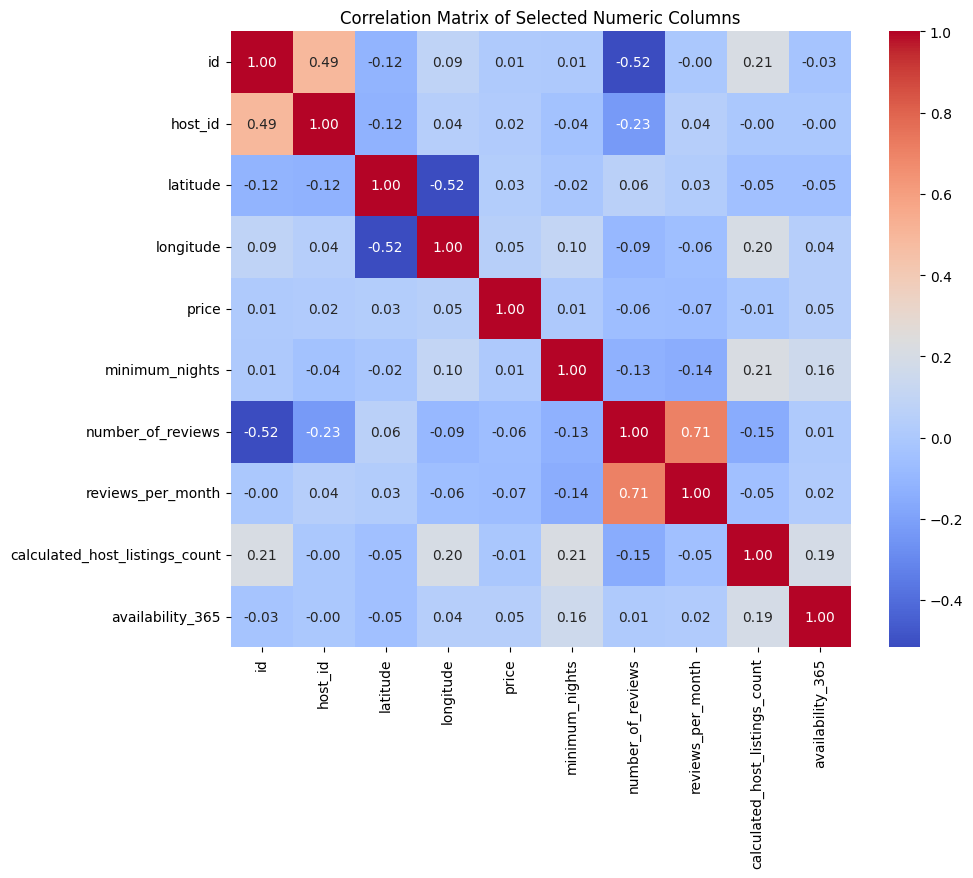

In [53]:
columns = df.columns

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols_filtered = [col for col in numeric_cols if col != 'neighbourhood_group']

df_numeric_filtered = df[numeric_cols_filtered]

corr_matrix = df_numeric_filtered.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Numeric Columns")
plt.show()




Strong Positive Correlation:

number_of_reviews and reviews_per_month (0.71): This strong positive correlation is expected. Listings that receive more reviews overall tend to have higher review frequencies per month.


Moderate Positive Correlations:
id and host_id (0.49): A moderate positive correlation suggests that listings with higher IDs tend to be associated with hosts who also have higher IDs. This might indicate a chronological pattern or a system-related association.

calculated_host_listings_count and availability_365 (0.19): A slight positive correlation here suggests that hosts with more listings might tend to have those listings available more often.

Moderate Negative Correlations:
latitude and longitude (-0.52): This indicates that as latitude increases longitude tends to decrease, or vice versa. This is likely due to the geographical shape of the city and the distribution of listings.

id and number_of_reviews (-0.52): A moderate negative correlation indicates that as listing ids increase, the number of reviews tend to decrease. This could mean that newer listings have less reviews.

minimum_nights and reviews_per_month (-0.14): A slight negative correlation suggests that listings with longer minimum stays might have slightly fewer reviews per month.

Weak Correlations:
Most other pairs of variables show weak correlations (close to 0). This suggests that there's not a strong linear relationship between those variables.
For instance price has relatively weak correlations with most other variables meaning that the price of listings is influenced by a combination of factors likely beyond just linear relationships.



In [54]:
columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'neighbourhood_group', 'last_review']
df = df.drop(columns=columns_to_drop)

Excluded Features :
id, host_id: These are unique identifiers that do not carry predictive information about price.

name, host_name: While potentially containing sentiment or subjective information these textual columns are difficult to process without extensive natural language processing and are unlikely to directly influence price in a predictable manner.

latitude, longitude:   While precise location data can be useful it often introduces complexity without adding significant predictive power. The neighbourhood column provides a categorical representation of location, which is easier to interpret and aligns with how guests typically search for listings. and Using both neighbourhood and precise coordinates (latitude, longitude) would introduce redundancy and increase model complexity unnecessarily. Furthermore the heatmap  does not show strong correlations between latitude,longitude and other key numerical features suggesting that their direct linear relationship with these features is limited.

neighbourhood_group: This column was removed as it contained null values for all rows rendering it useless for analysis.

last_review: This column was excluded due to a high percentage of missing values (1114 out of 6297 rows) which would require extensive imputation or removal potentially introducing bias. Additionally, the date of the last review is less informative than the frequency of reviews.

These feature selection choices are made to ensure that our model focuses on the most relevant and informative variables aligning with our analytical question and enhancing the model's predictive accuracy and interpretability.

# Handling missing values

In [55]:

df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


Missing Values of  reviews_per_month missing values were replaced with 0.A missing value in reviews_per_month likely indicates that the listing has not received any reviews. Replacing these missing values with 0 assumes that the absence of a review count means the listing has had no reviews rather than assuming some arbitrary non-zero value. This avoids introducing bias by imputing a value .


# Converting categorical variables

In [56]:

df = pd.get_dummies(df, columns=['room_type', 'neighbourhood'], drop_first=True)


The room_type and neighbourhood columns are categorical. These were converted into numerical format using one-hot encoding with pd.get_dummies. Machine learning models typically require numerical input. One-hot encoding converts each category into a binary column (0 or 1) allowing the model to understand and utilize the information contained in these categorical variables.The  drop_first=True parameter addresses the issue of multicollinearity. If n categories are present  we  only need n-1 dummy variables. For example if room_type has three categories (entire home, private room, shared room) we  only need two dummy variables. The third category is implicitly represented when both dummy variables are 0. Dropping the first category reduces redundancy and avoids making the model overly complex. This is a common practice in regression analysis to ensure that the model's coefficients are interpretable.

# Box plot of price

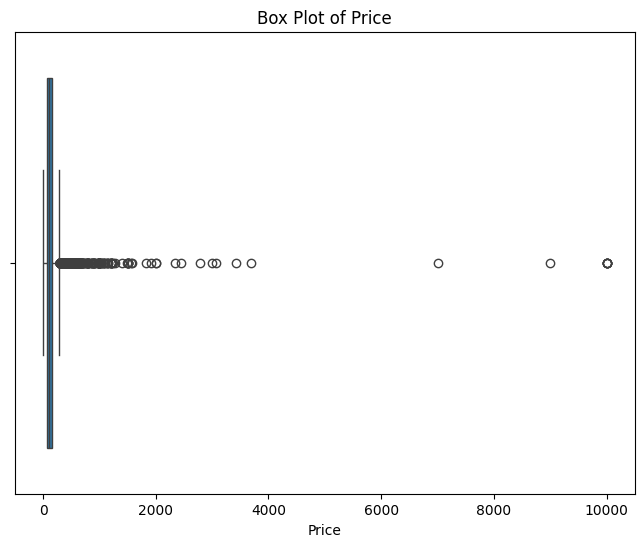

In [57]:

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of Price')
plt.xlabel('Price')
plt.show()

# Removing outliers using IQR 

In [58]:

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

The box plot of the price column before outlier removal reveals a right-skewed distribution with numerous data points extending far beyond the typical range indicating the presence of outliers. These outliers potentially representing data entry errors can significantly impact the performance of machine learning models by skewing predictions towards extreme values and reducing accuracy. Therefore i have chosen to employ the Interquartile Range (IQR) method for outlier removal due to its robustness to extreme values . By removing these outliers i aim to create a more representative dataset that will enhance the accuracy and robustness of Airbnb price prediction model ensuring it focuses on the typical range of prices relevant to the analysis.

In [8]:
cleaning_steps = pd.DataFrame({
    'field': ['reviews_per_month', 'room_type', 'neighbourhood', 'price'],
    'action': ['fillna(0)', 'one-hot encode', 'one-hot encode', 'IQR_trim'],
    'values': ['', '', '', f'({lower_bound:.2f}, {upper_bound:.2f})']
})



In [23]:
cleaning_steps

,field,action,values
0,reviews_per_month,fillna(0),
1,room_type,one-hot encode,
2,neighbourhood,one-hot encode,
3,price,IQR_trim,"(-72.50, 291.50)"


this indicates  the specific actions taken for columns such as filling missing reviews_per_month values with zero one-hot encoding room_type and neighbourhood and employing IQR trimming for the price column with the relevant numerical range of (-72.50, 291.50) clearly documented. This table serves as a crucial reference ensuring that these precise data cleaning steps can be consistently replicated when processing future live data

In [24]:
cleaning_steps.to_sql('cleaning_steps',db_conn , schema='cleaned', if_exists='replace', index=False)


4

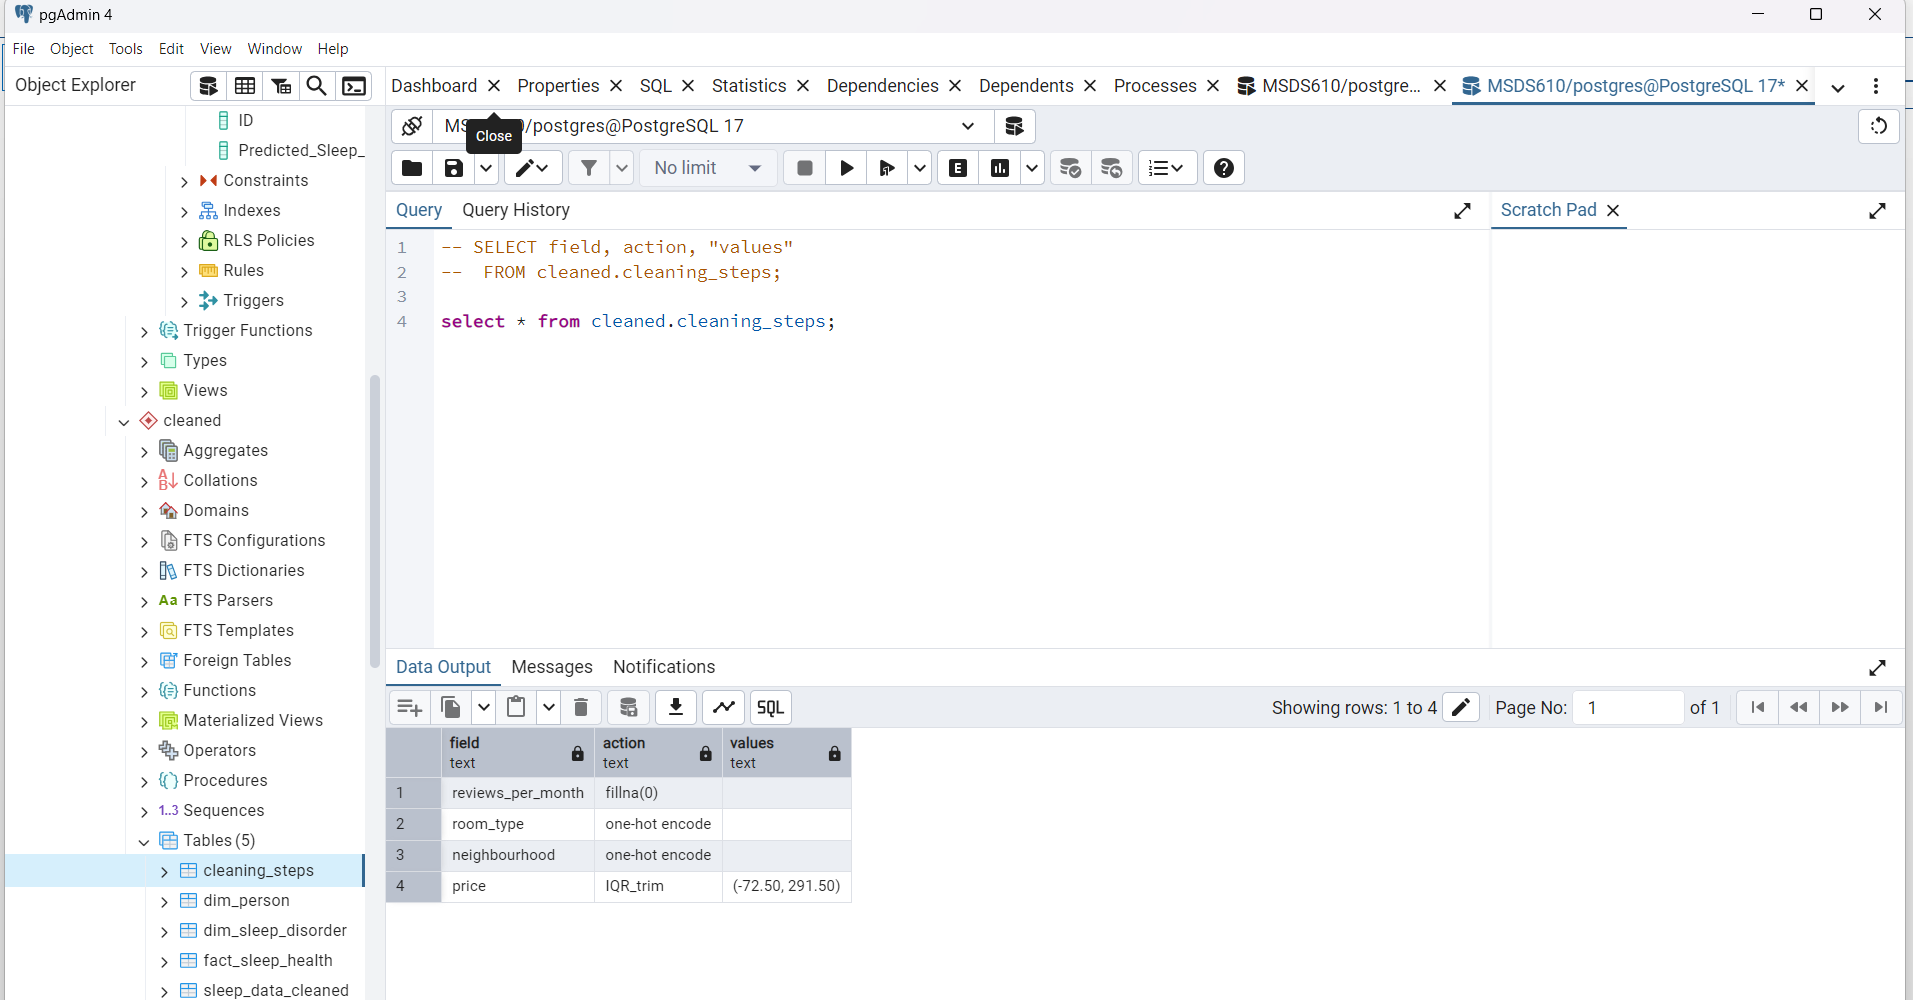

The cleaned.cleaning_steps table in the PostgreSQL database serves as a record of the data cleaning procedures applied to the Airbnb dataset as shown in the pgAdmin screenshot. With columns for field, action, and values, the table provides a clear overview of each cleaning step.  it shows that missing values in reviews_per_month were replaced with zeros room_type and neighbourhood were one-hot encoded and outliers in price were removed using the IQR method with the specific range of (-72.50, 291.50) noted. This table not only documents the cleaning process but also ensures that these transformations can be accurately replicated for future live data maintaining consistency and reproducibility in our analysis. 

# Part 5 –Feature Engineering and Final Prep

# Feature Engineering and Final Preparation 

# Feature Engineering

In [40]:

df['reviews_per_availability'] = df['number_of_reviews'] / (df['availability_365'] + 1)
df['price_per_night_min_nights'] = df['price'] / (df['minimum_nights'] + 1)
df['host_listings_per_review'] = df['calculated_host_listings_count'] / (df['number_of_reviews'] + 1)

Based on  analytical question i have developed the following new features to support our analysis:

reviews_per_availability : This feature calculates the average number of reviews a listing receives per available day. It is computed as number_of_reviews / (availability_365 + 1). The addition of 1 to the denominator prevents division by zero. This feature aims to capture the popularity of a listing relative to its availability. A higher value indicates that a listing is more popular and in demand which could influence its price.

price_per_night_min_nights: This feature calculates the effective price per night taking into account the minimum number of nights a guest must stay. It is computed as price / (minimum_nights + 1). The addition of 1 to the denominator prevents division by zero. This feature provides a more accurate view of the cost for short stays especially when minimum stay requirements are significant.
host_listings_per_review: This feature represents the ratio of host listings to reviews. It can act as a proxy for host activity or engagement.

These new features are expected to provide additional insights and improve the model's ability to predict Airbnb prices.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6396
Data columns (total 88 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   price                                 6297 non-null   int64  
 1   minimum_nights                        6297 non-null   int64  
 2   number_of_reviews                     6297 non-null   int64  
 3   reviews_per_month                     6297 non-null   float64
 4   calculated_host_listings_count        6297 non-null   int64  
 5   availability_365                      6297 non-null   int64  
 6   room_type_Hotel room                  6297 non-null   bool   
 7   room_type_Private room                6297 non-null   bool   
 8   room_type_Shared room                 6297 non-null   bool   
 9   neighbourhood_Archer Heights          6297 non-null   bool   
 10  neighbourhood_Armour Square           6297 non-null   bool   
 11  neighbourhood_Ashburn 

# Normalization

In [41]:




numerical_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count', 'availability_365',
                  'reviews_per_availability', 'price_per_night_min_nights', 'host_listings_per_review']

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

To ensure that our model is not biased by the scale of numerical features i have applied MinMaxScaler normalization to the above columns .MinMaxScaler scales each feature to the range [0, 1]. This ensures that all features contribute equally to the model and helps to improve the convergence and stability of the model. Normalization is important because machine learning algorithms can be sensitive to the scale of input features.By using MinMaxScaler, we ensured that all features are on the same scale which is particularly important for algorithms that rely on distance metrics or gradient-based optimization.

# Removing One Column

In [42]:
df = df.drop('host_listings_per_review', axis=1)

 based on domain knowledge i have decided  that host_listings_per_review does not significantly impact the target variable price. Removing it simplifies the model.so i am removing this

# Create feature engineering table

In [ ]:


feature_engineering = pd.DataFrame({
    'feature_name': ['reviews_per_availability', 'price_per_night_min_nights',
                     'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365'],
    'description': ['Average reviews per available day', 'Effective price per night considering minimum stay',
                    'Minimum nights', 'Number of reviews', 'Reviews per month',
                    'Calculated host listings count', 'Availability 365'],
    'normalization_method': ['MinMaxScaler', 'MinMaxScaler',
                             'MinMaxScaler', 'MinMaxScaler', 'MinMaxScaler',
                             'MinMaxScaler', 'MinMaxScaler'],
    'feature_type': ['engineered', 'engineered',
                     'original', 'original', 'original',
                     'original', 'original']
})

feature_engineering.to_sql('feature_engineering', db_conn, schema='cleaned', if_exists='replace', index=False)

7

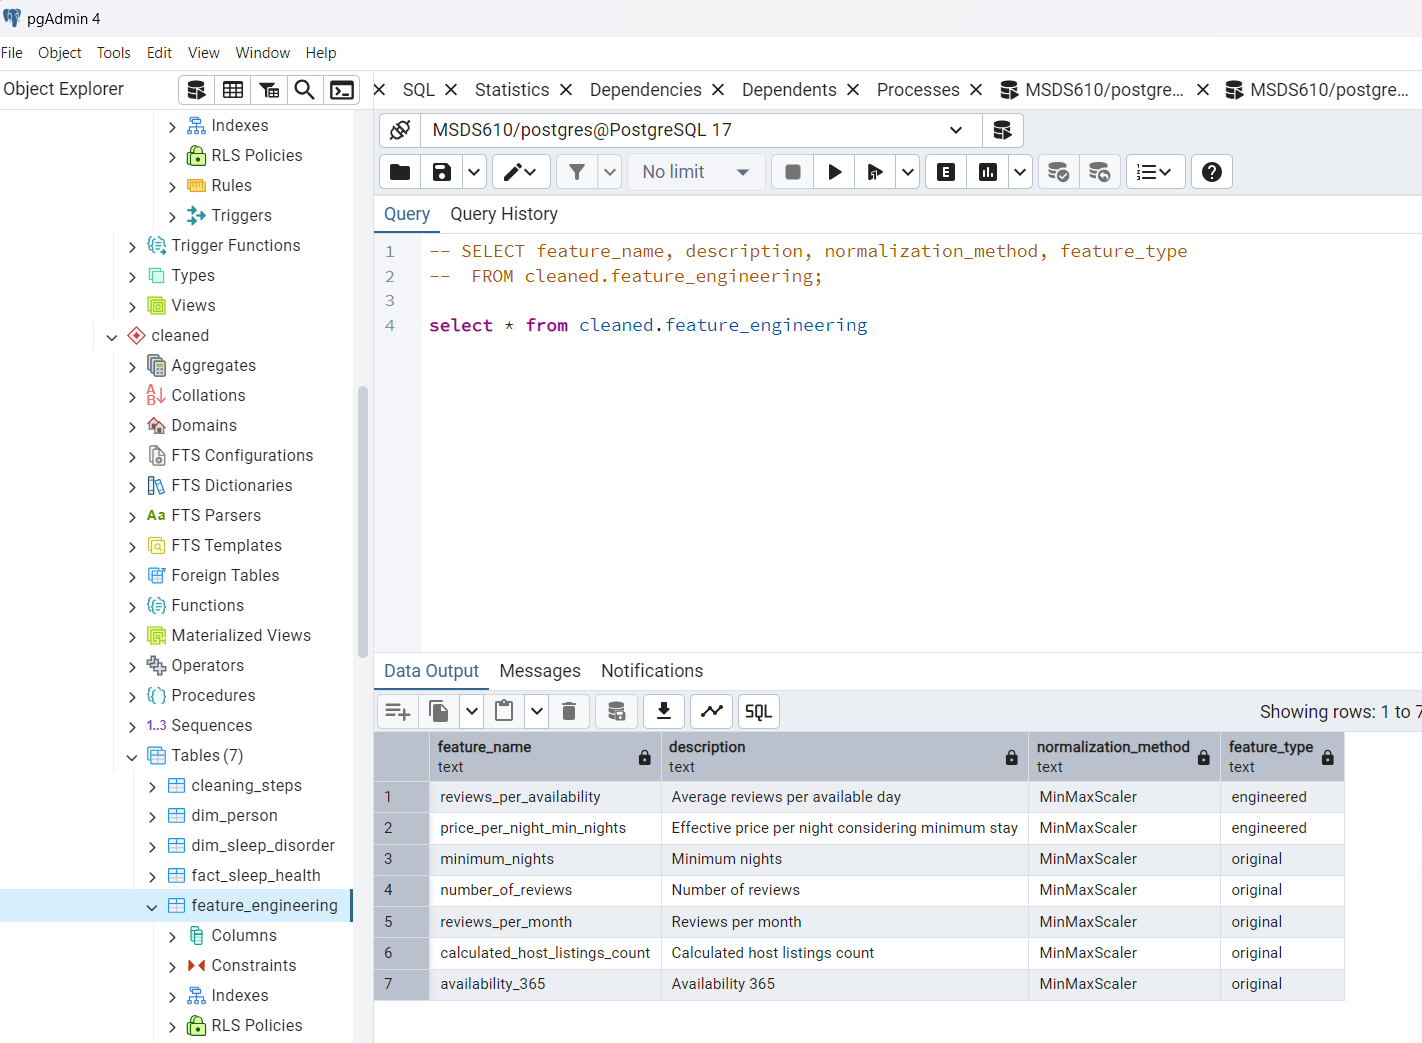

This table serves as a crucial record of the data preprocessing steps. It enhances reproducibility by clearly documenting the transformations applied to the features.
The feature_type column helps distinguish between engineered features created during the feature engineering process and original features that were normalized. This distinction is important for understanding the data transformation pipeline.
The description column provides context for each feature making it easier to understand its meaning and purpose.
The normalization_method column specifies the scaling technique used which is MinMaxScaler in this instance. MinMaxScaler scales the features to a range between 0 and 1.
By storing this information in the database it becomes readily accessible for future reference especially when applying the same transformations to new data .




In [21]:
df.to_sql('prepared_airbnb_data_final', db_conn, schema='cleaned', if_exists='replace', index=False)


123

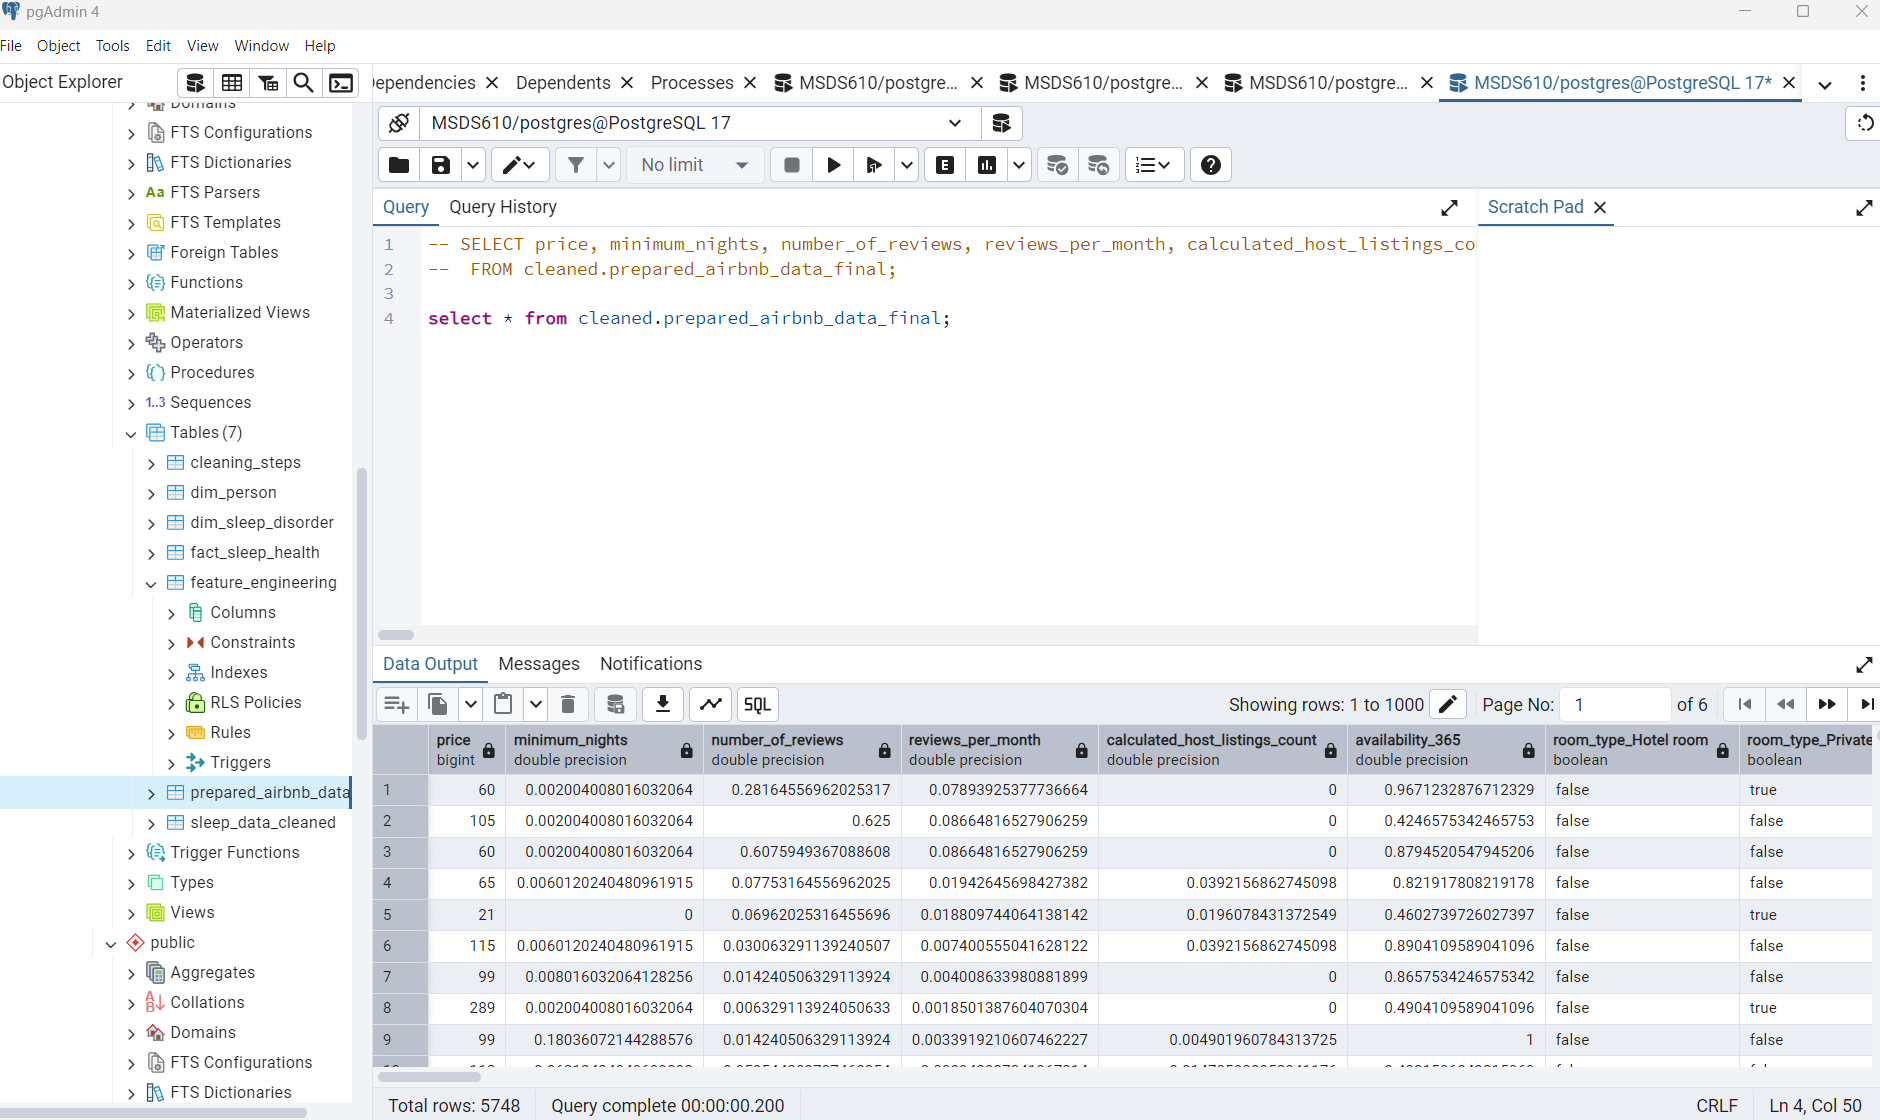

This table contains the final preprocessed dataset that will be used as input for training a machine learning model to predict Airbnb listing prices. The table includes both original features and engineered features providing a rich set of information for the model. The one-hot encoded room_type and neighbourhood columns represent categorical variables in a numerical format that machine learning models can readily use. The engineered features are designed to capture important relationships between variables that might influence the listing price. The data in this table has been normalized using MinMaxScaler ensuring that all numerical features are on a similar scale which can improve the performance and stability of machine learning algorithms. The table is stored in the cleaned schema indicating that the data has undergone cleaning and preparation.


In [22]:
df

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_Archer Heights,...,neighbourhood_West Elsdon,neighbourhood_West Englewood,neighbourhood_West Garfield Park,neighbourhood_West Lawn,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,reviews_per_availability,price_per_night_min_nights
0,60,0.002004,0.281646,0.078939,0.000000,0.967123,False,True,False,False,...,False,False,False,False,False,False,False,False,0.000805,0.143369
1,105,0.002004,0.625000,0.086648,0.000000,0.424658,False,False,False,False,...,False,False,False,False,False,False,False,False,0.004051,0.250896
2,60,0.002004,0.607595,0.086648,0.000000,0.879452,False,False,False,False,...,False,False,False,False,False,False,True,False,0.001908,0.143369
3,65,0.006012,0.077532,0.019426,0.039216,0.821918,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000260,0.093190
4,21,0.000000,0.069620,0.018810,0.019608,0.460274,False,True,False,False,...,False,False,False,False,False,False,False,False,0.000417,0.075269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,146,0.002004,0.000000,0.000000,0.014706,0.493151,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,0.348865
6392,146,0.002004,0.000000,0.000000,0.014706,0.493151,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,0.348865
6393,195,0.002004,0.000000,0.000000,0.014706,0.493151,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,0.465950
6395,53,0.062124,0.000000,0.000000,0.000000,0.227397,False,True,False,False,...,False,False,False,False,False,False,True,False,0.000000,0.011513


# Part 6 – Constructing an Optimal Model

# Prepare data for modeling

In [43]:

X = df.drop('price', axis=1)
y = df['price']

# 3-way split

In [44]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Algorithm Selection

For our Airbnb price prediction task we have chosen the RandomForestRegressor algorithm. This method offers several advantages that make it well suited for our problem:

Robustness: Random Forest is robust to outliers and noisy data which is important given the potential variability in Airbnb listing data.

Non-linear Relationships: It can effectively capture complex non-linear relationships between features and the target variable  which are likely to exist in real estate pricing.

Feature Importance: It provides a measure of feature importance allowing us to understand which factors have the most significant impact on Airbnb prices.

Reduced Overfitting: Compared to single decision trees Random Forest reduces the risk of overfitting by averaging predictions from multiple trees.

Handles Mixed Data: It can handle a mix of numerical and categorical features without requiring extensive preprocessing.


# Hyperparameter tuning and finding best model

In [45]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mean Squared Error: 45.27054199893112
R-squared: 0.9864680077952136


# Model saving

In [46]:

joblib.dump(best_model, 'airbnb_price_model.joblib')
print("Model saved as airbnb_price_model.joblib")

Model saved as airbnb_price_model.joblib


# Saving the validation dataset

In [47]:

val_data = pd.concat([X_val, y_val], axis=1)
val_data.to_csv('validation_data.csv', index=False)
print("Validation data saved as validation_data.csv")

Validation data saved as validation_data.csv



i constructed an optimal model using the RandomForestRegressor algorithm and evaluated its performance. First, the prepared data was split into training, validation, and test sets using a 3-way split method, where the training set  was used to train the model the validation set to tune hyperparameters via GridSearchCV and the test set  to evaluate final performance. The validation dataset was saved to 'validation_data.csv' for potential future use. GridSearchCV was used to find the best combination of hyperparameters for the RandomForestRegressor model tuning n_estimators , max_depth  min_samples_split  and min_samples_leaf . The best estimator was selected based on the cross-validation score. the trained model was evaluated on the test set  using Mean Squared Error (MSE) and R-squared (R2) as performance metrics. Finally the trained model was saved to a file named airbnb_price_model.joblib using joblib.dump to enable loading without retraining.

# summary

This notebook focuses on preparing the Chicago Airbnb dataset for predictive modeling to determine the optimal nightly price for Airbnb listings. The dataset was loaded and 100 rows were randomly sampled as live data with the remainder stored in a PostgreSQL database. Key steps included defining the data formulating an analytical question and selecting relevant features while dropping irrelevant ones. Missing values were handled outliers were removed and categorical variables were one-hot encoded. Two new features reviews_per_availability and price_per_night_min_nights were engineered to capture meaningful patterns and numerical features were normalized. The cleaned data and feature engineering steps were documented in the database. A Random Forest Regressor was chosen for its robustness and ability to handle non-linear relationships. The data was split into training, validation, and test sets and hyperparameter tuning was performed using GridSearchCV. The final model achieved an R² score of 0.98 and an MSE of 45.27 . The trained model was saved for use in Notebook 2 where it will be applied to live data for predictions.